In [41]:
import random
from datetime import datetime, timedelta
from IPython.display import display, HTML
import ipywidgets as widgets

# بيانات الفرق والملاعب والأوقات
teams = [
    "Al Ahly", "Zamalek", "Pyramids", "Masry", "Future", "Ismaily",
    "Smouha", "ENPPI", "Ceramica", "National Bank", "Talaea El Gaish",
    "Alexandria Union", "El Dakhleya", "El Gouna", "Zed",
    "Modern Sport", "Pharco", "Wadi Degla"
]

venues = [
    "Cairo Stadium", "Borg El Arab", "Air Defense Stadium",
    "Suez Stadium", "Alexandria Stadium", "Petro Sport Stadium",
    "Military Academy Stadium", "Al Salam Stadium", "El Sekka El Hadeed Stadium",
    "Zed Club Stadium"
]

match_times = ["17:00", "20:00"]

In [42]:
# مدة البطولة
start_date = datetime(2025, 5, 1)
end_date = datetime(2026, 1, 31)

# إعداد أيام البطولة
all_dates = []
current_date = start_date
while current_date <= end_date:
    all_dates.append(current_date)
    current_date += timedelta(days=1)

# تعريف الـ Match
class Match:
    def __init__(self, team1, team2, date, time, venue):
        self.team1 = team1
        self.team2 = team2
        self.date = date
        self.time = time
        self.venue = venue

    def __repr__(self):
        return f"{self.team1} vs {self.team2} on {self.date.strftime('%Y-%m-%d')} at {self.time} in {self.venue}"

# توليد جدول دوري أسبوعي مع تكرار المباريات مرتين
def generate_weekly_schedule(teams, venues, all_dates, match_times, min_rest_days=4):
    schedule = []
    last_played = {team: start_date - timedelta(days=min_rest_days) for team in teams}
    day_info = {d: {'count': 0, 'venues': set(), 'times': set()} for d in all_dates}
    pairings = [(t1, t2) for t1 in teams for t2 in teams if t1 != t2]
    random.shuffle(pairings)
    matches_count = {(t1, t2): 0 for t1 in teams for t2 in teams if t1 != t2}
    week_dates = all_dates[::7]

    for week_start in week_dates:
        used_teams = set()
        for home, away in pairings:
            if matches_count[(home, away)] >= 1:
                continue
            if home in used_teams or away in used_teams:
                continue
            possible_days = [d for d in all_dates if week_start <= d < week_start + timedelta(days=7)
                             and (d - last_played[home]).days >= min_rest_days
                             and (d - last_played[away]).days >= min_rest_days
                             and day_info[d]['count'] < 2]
            if not possible_days:
                continue
            random.shuffle(possible_days)
            for date in possible_days:
                available_times = [t for t in match_times if t not in day_info[date]['times']]
                available_venues = [v for v in venues if v not in day_info[date]['venues']]
                if not available_times or not available_venues:
                    continue
                time = random.choice(available_times)
                venue = random.choice(available_venues)
                match = Match(home, away, date, time, venue)
                schedule.append(match)
                last_played[home] = date
                last_played[away] = date
                matches_count[(home, away)] += 1
                used_teams.update([home, away])
                day_info[date]['count'] += 1
                day_info[date]['venues'].add(venue)
                day_info[date]['times'].add(time)
                break

    schedule.sort(key=lambda m: m.date)
    return schedule

# طباعة جدول كل فريق
def print_team_schedules(schedule):
    team_schedule = {team: [] for team in teams}
    for match in schedule:
        team_schedule[match.team1].append(match)
        team_schedule[match.team2].append(match)
    for team, matches in team_schedule.items():
        print(f"\n=== Schedule for {team} ===")
        matches.sort(key=lambda m: m.date)
        for m in matches:
            opponent = m.team2 if m.team1 == team else m.team1
            print(f"{m.date.strftime('%Y-%m-%d')} at {m.time} vs {opponent} in {m.venue}")

# توليد عدة احتمالات
num_possibilities = 5
all_possible_schedules = [generate_weekly_schedule(teams, venues, all_dates, match_times) for _ in range(num_possibilities)]

# طباعة أول 5 احتمالات
# for i, schedule in enumerate(all_possible_schedules):
#     print(f"\n=== Schedule {i+1} ===")
#     for m in schedule[:10]:  # أول 10 مباريات لكل جدول
#         print(m)
#     print_team_schedules(schedule)  # جدول كل فريق


In [43]:
# دالة لتوليد جدول Baseline
def generate_baseline_schedule():
    pairings = [(t1, t2) for i, t1 in enumerate(teams) for t2 in teams[i+1:]]
    random.shuffle(pairings)
    
    schedule = []
    day_index = 0
    for home, away in pairings:
        date = all_dates[day_index % len(all_dates)]
        time = random.choice(match_times)
        venue = random.choice(venues)
        schedule.append(Match(home, away, date, time, venue))
        day_index += 1

    global baseline_schedule
    baseline_schedule = schedule
    return schedule

# زرار لتوليد Baseline Schedule
generate_baseline_button = widgets.Button(
    description="Generate Baseline Schedule",
    button_style='success'
)

baseline_output = widgets.Output()

def show_baseline_schedule(b):
    with baseline_output:
        clear_output(wait=True)
        baseline_schedule = generate_baseline_schedule()
        html = "<h2>Baseline Schedule</h2><table border='1' style='border-collapse: collapse;'>"
        html += "<tr><th>Date</th><th>Time</th><th>Home</th><th>Away</th><th>Venue</th></tr>"
        for match in baseline_schedule:
            html += f"<tr><td>{match.date.strftime('%Y-%m-%d')}</td><td>{match.time}</td><td>{match.team1}</td><td>{match.team2}</td><td>{match.venue}</td></tr>"
        html += "</table>"
        display(HTML(html))

generate_baseline_button.on_click(show_baseline_schedule)
display(generate_baseline_button, baseline_output)


Button(button_style='success', description='Generate Baseline Schedule', style=ButtonStyle())

Output()

In [44]:
import pandas as pd

def generate_baseline_schedule():
    # توليد جميع المباريات الممكنة (Round-Robin)
    pairings = [(t1, t2) for i, t1 in enumerate(teams) for t2 in teams[i+1:]]
    random.shuffle(pairings)
    
    # توزيع المباريات على الأيام والملاعب والأوقات
    schedule = []
    day_index = 0
    for home, away in pairings:
        date = all_dates[day_index % len(all_dates)]
        time = random.choice(match_times)
        venue = random.choice(venues)
        schedule.append(Match(home, away, date, time, venue))
        day_index += 1
    
    # حفظ baseline للمرحلة القادمة
    global baseline_schedule
    baseline_schedule = schedule
    return schedule


In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# دالة الرسم للفريق
# -----------------------------
def plot_team_schedule_visual(team, schedule):
    # تصفية المباريات الخاصة بالفريق
    team_matches = [m for m in schedule if m.team1 == team or m.team2 == team]
    team_matches.sort(key=lambda m: m.date)
    
    fig, ax = plt.subplots(figsize=(12, len(team_matches)*0.6))
    
    dates = [m.date for m in team_matches]
    opponents = [m.team2 if m.team1 == team else m.team1 for m in team_matches]
    times = [m.time for m in team_matches]
    venues = [m.venue for m in team_matches]
    
    date_nums = mdates.date2num(dates)
    
    # رسم كل مباراة كـ bar أفقية ملونة
    for i, (d, opp, t, v) in enumerate(zip(date_nums, opponents, times, venues)):
        ax.barh(i, width=0.8, left=d, height=0.5, color=plt.cm.tab20(i % 20))
        ax.text(d + 0.2, i, f"{opp} @ {t} ({v})", va='center', color='black', fontsize=10)
    
    # ضبط محور X ليعرض التواريخ
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    # محاور Y
    ax.set_yticks(range(len(team_matches)))
    ax.set_yticklabels([f"Match {i+1}" for i in range(len(team_matches))])
    ax.set_title(f"Schedule for {team}")
    ax.set_ylabel("Matches")
    
    plt.tight_layout()
    plt.show()

# -----------------------------
# إعداد الـ GUI
# -----------------------------
# Dropdown لاختيار الفريق
team_dropdown_baseline = widgets.Dropdown(
    options=teams,
    description="Team:",
    disabled=False
)

# Output widget للرسم
baseline_output = widgets.Output()

# زرار للرسم
plot_button = widgets.Button(description="Plot Team Schedule")

# الدالة المسؤولة عن الرسم عند الضغط
def plot_selected_team(b):
    with baseline_output:
        clear_output(wait=True)  # يمسح الرسم القديم
        plot_team_schedule_visual(team_dropdown_baseline.value, baseline_schedule)

plot_button.on_click(plot_selected_team)

# عرض الـ widgets و output
display(team_dropdown_baseline, plot_button, baseline_output)


Dropdown(description='Team:', options=('Al Ahly', 'Zamalek', 'Pyramids', 'Masry', 'Future', 'Ismaily', 'Smouha…

Button(description='Plot Team Schedule', style=ButtonStyle())

Output()

In [47]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Dropdown لاختيار الاحتمال
schedule_dropdown = widgets.Dropdown(
    options=[f"Schedule {i+1}" for i in range(num_possibilities)],
    description="Choose:",
    disabled=False
)

# Dropdown لاختيار نوع العرض
view_dropdown = widgets.Dropdown(
    options=["Full League Schedule", "Team Schedule"],
    description="View:",
    disabled=False
)

# Dropdown لاختيار الفريق
team_dropdown = widgets.Dropdown(
    options=teams,
    description="Team:",
    disabled=False
)

# زرار للعرض
button = widgets.Button(description="Show Schedule")

# Output area
output = widgets.Output()

# الدالة المسؤولة عن العرض
def show_schedule(b):
    with output:
        clear_output(wait=True)  # يمسح الجدول القديم قبل العرض
        selected_index = int(schedule_dropdown.value.split()[1]) - 1
        schedule = all_possible_schedules[selected_index]
        view = view_dropdown.value
        if view == "Full League Schedule":
            html = "<h2>Full League Schedule</h2><table border='1' style='border-collapse: collapse;'>"
            html += "<tr><th>Date</th><th>Time</th><th>Home</th><th>Away</th><th>Venue</th></tr>"
            for match in schedule:
                html += f"<tr><td>{match.date.strftime('%Y-%m-%d')}</td><td>{match.time}</td><td>{match.team1}</td><td>{match.team2}</td><td>{match.venue}</td></tr>"
            html += "</table>"
            display(HTML(html))
        else:
            team = team_dropdown.value
            team_matches = [m for m in schedule if m.team1 == team or m.team2 == team]
            html = f"<h2>Schedule for {team}</h2><table border='1' style='border-collapse: collapse;'>"
            html += "<tr><th>Date</th><th>Time</th><th>Opponent</th><th>Venue</th></tr>"
            for match in team_matches:
                opponent = match.team2 if match.team1 == team else match.team1
                html += f"<tr><td>{match.date.strftime('%Y-%m-%d')}</td><td>{match.time}</td><td>{opponent}</td><td>{match.venue}</td></tr>"
            html += "</table>"
            display(HTML(html))

button.on_click(show_schedule)
# عنوان للواجهة
display(HTML("<h1>Sports Tournament Scheduling</h1><p>Select a schedule and view options below:</p>"))

# Function لتفعيل/إخفاء dropdown الفريق حسب نوع العرض
def update_team_dropdown(*args):
    if view_dropdown.value == "Team Schedule":
        team_dropdown.layout.display = 'block'
    else:
        team_dropdown.layout.display = 'none'

view_dropdown.observe(update_team_dropdown, 'value')
update_team_dropdown()


# عرض الـ widgets
display(schedule_dropdown, view_dropdown, team_dropdown, button, output)


Dropdown(description='Choose:', options=('Schedule 1', 'Schedule 2', 'Schedule 3', 'Schedule 4', 'Schedule 5')…

Dropdown(description='View:', options=('Full League Schedule', 'Team Schedule'), value='Full League Schedule')

Dropdown(description='Team:', layout=Layout(display='none'), options=('Al Ahly', 'Zamalek', 'Pyramids', 'Masry…

Button(description='Show Schedule', style=ButtonStyle())

Output()

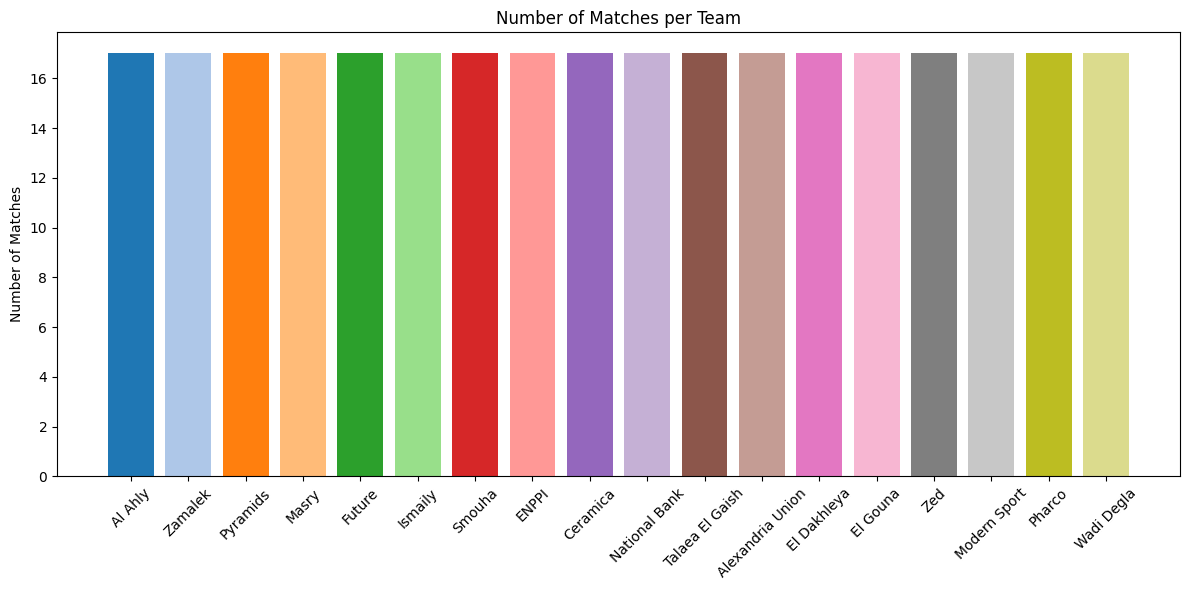

In [52]:
def plot_matches_distribution(schedule):
    team_counts = {team: 0 for team in teams}
    for match in schedule:
        team_counts[match.team1] += 1
        team_counts[match.team2] += 1
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(team_counts.keys(), team_counts.values(), color=plt.cm.tab20.colors)
    ax.set_ylabel("Number of Matches")
    ax.set_title("Number of Matches per Team")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# مثال للاستخدام:
plot_matches_distribution(baseline_schedule)


In [48]:
def compute_fitness_verbose(schedule, min_rest_days=4, weights=None):
    if weights is None:
        weights = {'venue_conflict': 1.0, 'rest_violation': 0.7, 'repeated_opponent': 0.0, 'time_balance': 0.3}

    penalty = 0
    venue_day_time = {}
    last_played = {}
    matches_per_pair = {}
    team_times = {}

    venue_conflict_count = 0
    rest_violation_count = 0
    repeated_opponents_count = 0
    time_balance_penalty = 0

    for match in schedule:
        key = (match.date, match.time, match.venue)
        if key in venue_day_time:
            penalty += weights['venue_conflict']
            venue_conflict_count += 1
        else:
            venue_day_time[key] = True

        for team in [match.team1, match.team2]:
            if team in last_played:
                delta_days = (match.date - last_played[team]).days
                if delta_days < min_rest_days:
                    penalty += weights['rest_violation']
                    rest_violation_count += 1
            last_played[team] = match.date

        pair = tuple(sorted([match.team1, match.team2]))
        if pair in matches_per_pair:
            penalty += weights['repeated_opponent']
            repeated_opponents_count += 1
        matches_per_pair[pair] = matches_per_pair.get(pair,0) + 1

        for team in [match.team1, match.team2]:
            if team not in team_times:
                team_times[team] = {}
            team_times[team][match.time] = team_times[team].get(match.time,0) + 1

    for team, times in team_times.items():
        if len(times) > 1:
            diff = abs(times.get('17:00',0) - times.get('20:00',0))
            penalty += diff * weights['time_balance']
            time_balance_penalty += diff

    fitness = max(0, 100 - penalty)

    print(f"Fitness: {fitness}")
    print(f"Venue conflicts: {venue_conflict_count}, Rest violations: {rest_violation_count}, Repeated opponents: {repeated_opponents_count}, Time balance penalty: {time_balance_penalty}")

    return fitness



In [49]:
best_score = -1
best_schedule = None

for schedule in all_possible_schedules:
    score = compute_fitness_verbose(schedule)
    if score > best_score:
        best_score = score
        best_schedule = schedule

print(f"Best fitness: {best_score}")


Fitness: 76.0
Venue conflicts: 0, Rest violations: 0, Repeated opponents: 153, Time balance penalty: 80
Fitness: 82.0
Venue conflicts: 0, Rest violations: 0, Repeated opponents: 153, Time balance penalty: 60
Fitness: 71.2
Venue conflicts: 0, Rest violations: 0, Repeated opponents: 153, Time balance penalty: 96
Fitness: 78.4
Venue conflicts: 0, Rest violations: 0, Repeated opponents: 153, Time balance penalty: 72
Fitness: 77.19999999999999
Venue conflicts: 0, Rest violations: 0, Repeated opponents: 153, Time balance penalty: 76
Best fitness: 82.0
